### Filter CT

In [ ]:
import pandas as pd
import numpy as np
import os
import pydicom
from pydicom.errors import InvalidDicomError
from PIL import Image
from collections import Counter
from sklearn.model_selection import train_test_split

In [ ]:
# Load the CSV file
data_path = '/mnt/win_share/GitHub/AI-ethnicity-med-image/data/NLST_CT_withPID.csv'
df = pd.read_csv(data_path)

c:\Users\yuting.tseng\AppData\Local\anaconda3\envs\dicom_env\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [39]:
# Define race mapping and filter relevant columns
race_mapping = {
    1: "White",
    2: "Black or African-American",
    3: "Asian",
    4: "American Indian or Alaskan Native",
    5: "Native Hawaiian or Other Pacific Islander"
}
df['Patient Race'] = df['Patient Race'].map(race_mapping)

# Drop rows where 'Patient Race' is NaN
df_cleaned = df.dropna(subset=['Patient Race'])

In [40]:
current_path = os.getcwd()
print(current_path)

E:\Data\NLST\Radiology CT Images\manifest-NLST_allCT


In [41]:
# Change to current directory
os.chdir(r'E:\Data\NLST\Radiology CT Images\manifest-NLST_allCT')
print(os.getcwd())

E:\Data\NLST\Radiology CT Images\manifest-NLST_allCT


In [45]:
# Function to filter lung CT images with error handling
def filter_lung_ct_images(df, output_csv='filtered_lung_ct_images.csv'):
    lung_ct_files = []
    metadata_counts = {
        'Lung CT': 0,
        'Other CT': 0,
        'Non-CT': 0,
        'Unknown': 0
    }
    
    for index, row in df.iterrows():
        dicom_folder = row['File Location']
        dicom_files = [f for f in os.listdir(dicom_folder) if f.endswith('.dcm')]
        
        if dicom_files:
            dicom_file = dicom_files[0]  # Select the first DICOM file
            dicom_path = os.path.join(dicom_folder, dicom_file)
            
            try:
                # Try reading the DICOM file with error handling
                ds = pydicom.dcmread(dicom_path, force=True)  # Use force=True to attempt reading non-standard files

                # Check Modality and BodyPartExamined for filtering
                modality = ds.get("Modality", "Unknown")
                body_part = ds.get("BodyPartExamined", "Unknown")

                # Classify based on modality and body part
                if modality == "CT" and ("LUNG" in body_part.upper() or "CHEST" in body_part.upper()):
                    metadata_counts['Lung CT'] += 1
                    lung_ct_files.append({
                        "Subject ID": row["Subject ID"],
                        "File Location": dicom_folder,
                        "Patient Race": row["Patient Race"]
                    })
                elif modality == "CT":
                    metadata_counts['Other CT'] += 1
                elif modality != "Unknown":
                    metadata_counts['Non-CT'] += 1
                else:
                    metadata_counts['Unknown'] += 1

            except InvalidDicomError:
                print(f"Skipping invalid DICOM file: {dicom_path}")
                metadata_counts['Unknown'] += 1  # Count as unknown if it's an invalid DICOM

    # Print metadata counts
    print("Metadata Counts:")
    for key, count in metadata_counts.items():
        print(f"{key}: {count}")

    # Convert the list of lung CT files to a DataFrame and save to CSV
    lung_ct_df = pd.DataFrame(lung_ct_files)
    lung_ct_df.to_csv(output_csv, index=False)
    print(f"Filtered lung CT image paths saved to {output_csv}")

    return lung_ct_df

# Apply the filter function
lung_ct_df = filter_lung_ct_images(df_cleaned)

Metadata Counts:
Lung CT: 191223
Other CT: 8712
Non-CT: 0
Unknown: 1
Filtered lung CT image paths saved to filtered_lung_ct_images.csv


In [58]:
# Function to inspect orientations and views in the dataset
def inspect_orientation_and_view(df):
    orientation_counter = Counter()
    view_counter = Counter()
    total_files = 0
    
    for index, row in df.iterrows():
        dicom_folder = row['File Location']
        dicom_files = [f for f in os.listdir(dicom_folder) if f.endswith('.dcm')]
        
        if dicom_files:
            dicom_file = dicom_files[0]  # Select the first DICOM file
            dicom_path = os.path.join(dicom_folder, dicom_file)
            try:
                # Attempt to read the DICOM file
                ds = pydicom.dcmread(dicom_path, force=True)
                total_files += 1

                # Get orientation and view metadata
                orientation = ds.get("ImageOrientationPatient", "Unknown")
                view_position = ds.get("ViewPosition", "Unknown")

                # Update counters
                orientation_counter[tuple(orientation)] += 1 if orientation != "Unknown" else 0
                view_counter[view_position] += 1 if view_position != "Unknown" else 0

            except InvalidDicomError:
                print(f"Invalid DICOM file skipped: {dicom_path}")
            except Exception as e:
                print(f"Error reading file {dicom_path}: {e}")

    # Print the summary of orientations and views
    print(f"\nTotal DICOM files inspected: {total_files}")
    print("\nOrientation Counts (ImageOrientationPatient):")
    for orientation, count in orientation_counter.items():
        print(f"{orientation}: {count}")
    
    print("\nView Position Counts (ViewPosition):")
    for view, count in view_counter.items():
        print(f"{view}: {count}")

# Run the inspection
inspect_orientation_and_view(df_cleaned)


Total DICOM files inspected: 199936

Orientation Counts (ImageOrientationPatient):
('0.0', '-1.0', '0.0', '0.0', '0.0', '-1.0'): 21747
('1.0', '0.0', '0.0', '0.0', '1.0', '0.0'): 135425
('1.0', '0.0', '0.0', '0.0', '0.0', '-1.0'): 22052
('1.0', '-7.0448747e-16', '0.0', '0.0', '0.0', '-1.0'): 4430
('0.0', '1.0', '0.0', '0.0', '0.0', '-1.0'): 5550
('1.0', '6.123031769e-17', '0.0', '0.0', '0.0', '-1.0'): 1398
('1.0', '6.1230318e-17', '0.0', '0.0', '0.0', '-1.0'): 5242
('-1.0', '0.0', '0.0', '0.0', '0.0', '-1.0'): 970
('1.0', '-7.04487467e-16', '0.0', '0.0', '0.0', '-1.0'): 98
('-1.0', '0.0', '0.0', '0.0', '-1.0', '0.0'): 170
('-1.0', '0.0', '0.0', '0.0', '1.0', '0.0'): 10
('1.0', '7.0448747e-16', '0.0', '0.0', '0.0', '-1.0'): 1200
('1.0', '-6.12303177e-17', '0.0', '0.0', '0.0', '-1.0'): 592
('-1.0', '-6.1230318e-17', '0.0', '0.0', '0.0', '-1.0'): 1
('1.0', '7.044874666e-16', '0.0', '0.0', '0.0', '-1.0'): 18
('1.0', '-6.1230318e-17', '0.0', '0.0', '0.0', '-1.0'): 904
('1.0', '0.0', '0.0',

In [59]:
# Function to filter DICOM files by ImageType and save axial lung CT files to CSV
def axial_lung_ct_images(df, output_csv='axial_lung_ct_images.csv'):
    axial_lung_ct_files = []
    metadata_counts = {
        'Axial Lung CT': 0,
        'Other CT': 0,
        'Non-CT': 0,
        'Invalid DICOM': 0,
        'Unknown': 0
    }
    
    for index, row in df.iterrows():
        dicom_folder = row['File Location']
        dicom_files = [f for f in os.listdir(dicom_folder) if f.endswith('.dcm')]
        
        if dicom_files:
            dicom_file = dicom_files[0]  # Select the first DICOM file
            dicom_path = os.path.join(dicom_folder, dicom_file)
            try:
                # Attempt to read the DICOM file
                ds = pydicom.dcmread(dicom_path, force=True)

                # Check Modality, BodyPartExamined, and ImageType for axial lung CT
                modality = ds.get("Modality", "Unknown")
                body_part = ds.get("BodyPartExamined", "Unknown")
                image_type = "\\".join(ds.get("ImageType", []))  # Convert list to string

                # Filter for axial lung CTs with ImageType 'ORIGINAL\PRIMARY\AXIAL'
                if (modality == "CT" and 
                    ("LUNG" in body_part.upper() or "CHEST" in body_part.upper()) and
                    image_type == "ORIGINAL\\PRIMARY\\AXIAL"):

                    metadata_counts['Axial Lung CT'] += 1
                    axial_lung_ct_files.append({
                        "Subject ID": row["Subject ID"],
                        "File Location": dicom_folder,
                        "Patient Race": row["Patient Race"]
                    })

                elif modality == "CT":
                    metadata_counts['Other CT'] += 1
                elif modality != "Unknown":
                    metadata_counts['Non-CT'] += 1
                else:
                    metadata_counts['Unknown'] += 1

            except InvalidDicomError:
                metadata_counts['Invalid DICOM'] += 1
                print(f"Invalid DICOM file skipped: {dicom_path}")
            except Exception as e:
                print(f"Error reading file {dicom_path}: {e}")

    # Print metadata counts
    print("Metadata Counts:")
    for key, count in metadata_counts.items():
        print(f"{key}: {count}")

    # Convert the list of axial lung CT files to a DataFrame and save to CSV
    axial_lung_ct_df = pd.DataFrame(axial_lung_ct_files)
    axial_lung_ct_df.to_csv(output_csv, index=False)
    print(f"Filtered axial lung CT image paths saved to {output_csv}")

    return axial_lung_ct_df

# Run the filtering function and save to CSV
axial_lung_ct_df = axial_lung_ct_images(df_cleaned)

Metadata Counts:
Axial Lung CT: 67659
Other CT: 132276
Non-CT: 0
Invalid DICOM: 0
Unknown: 1
Filtered axial lung CT image paths saved to axial_lung_ct_images.csv


In [46]:
num_ctimages = len(lung_ct_df)
print(f"Number of available CT: {num_ctimages}")

# Check the new class distribution
print("Filtered CT - Class Distribution:")
print(lung_ct_df['Patient Race'].value_counts())

Number of available CT: 191223
Filtered CT - Class Distribution:
White                                        179108
Black or African-American                      7685
Asian                                          3303
American Indian or Alaskan Native               633
Native Hawaiian or Other Pacific Islander       494
Name: Patient Race, dtype: int64


In [60]:
num_axctimages = len(axial_lung_ct_df)
print(f"Number of available CT: {num_axctimages}")

# Check the new class distribution
print("Filtered CT - Class Distribution:")
print(axial_lung_ct_df['Patient Race'].value_counts())

Number of available CT: 67659
Filtered CT - Class Distribution:
White                                        63349
Black or African-American                     2302
Asian                                         1563
Native Hawaiian or Other Pacific Islander      225
American Indian or Alaskan Native              220
Name: Patient Race, dtype: int64


### Try with updated CSV

In [2]:
# Load the CSV file
data_path = 'U:/GitHub/AI-ethnicity-med-image/data/axial_lung_ct_images.csv'
df_axaial = pd.read_csv(data_path)

In [3]:
# Change to current directory
os.chdir(r'E:\Data\NLST\Radiology CT Images\manifest-NLST_allCT')
print(os.getcwd())

E:\Data\NLST\Radiology CT Images\manifest-NLST_allCT


In [4]:
# Group by 'Subject ID' to handle multiple images per patient
grouped = df_axaial.groupby('Subject ID')

# Randomly select one image per patient
df_single_image_per_patient = grouped.apply(lambda x: x.sample(1, random_state=42)).reset_index(drop=True)

# Label mapping for converting race categories to integers
label_mapping = {
    "White": 0,
    "Black or African-American": 1,
    "Asian": 2,
    "American Indian or Alaskan Native": 3,
    "Native Hawaiian or Other Pacific Islander": 4
}

# Convert the 'Patient Race' to integer labels
df_single_image_per_patient['Race_Label'] = df_single_image_per_patient['Patient Race'].map(label_mapping)

In [5]:
num_patients = df_single_image_per_patient['Subject ID'].nunique()
num_images = len(df_single_image_per_patient)

# Print the results
print(f"Number of unique patients: {num_patients}")
print(f"Number of images after selecting one per patient: {num_images}")

Number of unique patients: 15639
Number of images after selecting one per patient: 15639


Class distribution after cleaning:
White                                        14435
Black or African-American                      584
Asian                                          491
Native Hawaiian or Other Pacific Islander       81
American Indian or Alaskan Native               48
Name: Patient Race, dtype: int64


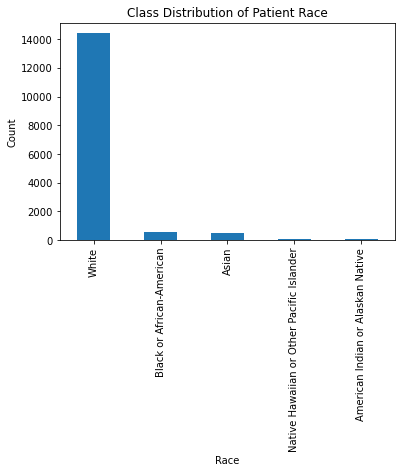

In [6]:
import matplotlib.pyplot as plt
# Check class distribution
print("Class distribution after cleaning:")
print(df_single_image_per_patient['Patient Race'].value_counts())

# Plot class distribution
df_single_image_per_patient['Patient Race'].value_counts().plot(kind='bar', title="Class Distribution of Patient Race", xlabel="Race", ylabel="Count")
plt.show()

In [7]:
# Sample a maximum number of images per patient (1 image per unique patient)
sampled_df = df_single_image_per_patient.sample(n=1500, random_state=42)

print("Shape of the cleaned DataFrame:", sampled_df.shape)

Shape of the cleaned DataFrame: (1500, 4)


In [8]:
# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    sampled_df['File Location'],
    sampled_df['Race_Label'],
    test_size=0.2,
    stratify=sampled_df['Race_Label'],
    random_state=42
)

In [9]:
# Preprocessing function to standardize lung CT images
def preprocess_images(file_paths, labels):
    image_data = []
    processed_labels = []
    
    # Ensure only one image per patient (process the first DICOM file found)
    for file_path, label in zip(file_paths, labels):
        dicom_folder = file_path  # Path to the folder containing DICOM images
        dicom_files = [f for f in os.listdir(dicom_folder) if f.endswith('.dcm')]  # List DICOM files
        
        if dicom_files:
            dicom_file = dicom_files[0]  # Select the first DICOM file only
            dicom_path = os.path.join(dicom_folder, dicom_file)
            ds = pydicom.dcmread(dicom_path)  # Read the DICOM file
            img_array = ds.pixel_array  # Extract pixel array

            # Normalize the image
            img_array = img_array / np.max(img_array)  # Normalize to [0, 1]

            # Resize the image
            img = Image.fromarray(img_array)  # Convert to PIL image
            img = img.resize((224, 224))  # Resize to 224x224 pixels
            img_array_resized = np.array(img)  # Convert back to numpy array

            # Convert grayscale image to 3-channel RGB by repeating the single channel 3 times
            img_array_rgb = np.stack([img_array_resized] * 3, axis=-1)

            image_data.append(img_array_rgb)
            processed_labels.append(label)  # Append the corresponding label
    
    return np.array(image_data), np.array(processed_labels)

In [10]:
# Preprocess images for training and validation sets (ensure 1 image per patient)
X_train_images, y_train_labels = preprocess_images(X_train, y_train)
X_val_images, y_val_labels = preprocess_images(X_val, y_val)

In [11]:
# Check the number of images
num_train_images = X_train_images.shape[0]
num_val_images = X_val_images.shape[0]

print(f"Number of training images: {num_train_images}")
print(f"Number of validation images: {num_val_images}")
print(f"Number of training labels: {len(y_train_labels)}")
print(f"Number of validation labels: {len(y_val_labels)}")


Number of training images: 1200
Number of validation images: 300
Number of training labels: 1200
Number of validation labels: 300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


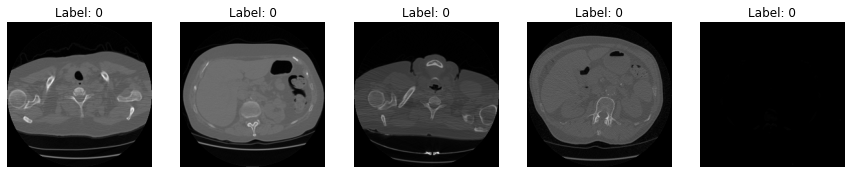

In [14]:
def show_images(images, labels, num_images=5):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()

# Display the first few images in the training set
show_images(X_train_images, y_train_labels)